# SSIB analysis walk through
## To DO 0
1. Create a git repo
2. After each to do, commit and push your changes to the repo (I am going to look at this analysis using the git repo, I should see updates in this notebook at each commit corresponding to the to do)
3. Add the Rmd to the git repo as well. THE GIT REPO SHOULD NOT HAVE ANY DATA IN IT

# Notes
## Features
The X dataframe is your "features". Right now there are too many features for the number of subjects. A good rule of thumb is your features should be 10% or less than your number of samples (subjects). Since we are going to be doing training and testing, we need to limit the number of features to our final testing dataset
## Samples
This is the number of subjects in our dataset
## Targets
This is what we are trying to predict. Right now we are trying to predict the high and low SSB groups based on the features.

In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered


In [2]:
import statsmodels.api as sm
import pandas as pd
import nilearn
import numpy as np
import glob 
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


from sklearn.model_selection import cross_val_score
from pathlib import Path

from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import seaborn as sns

import nibabel as nib
#from nilearn.input_data import NiftiLabelsMasker
#I got a warning that nilearn.input_data is deprecated, so I imported from nilearn.maskers instead
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score



%matplotlib inline

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Load the data
Change the path as needed

In [3]:
basepath = '/Users/gracer/Library/CloudStorage/OneDrive-UniversityofWyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/ABCD/Yana_SSIB_2024/'
#Yana windows
#basepath = r'C:\Users\Yanko\OneDrive - University of Wyoming\Desktop - Copy\Lab\SSIB 2024'

^ Why are you working off the OneDrive :/

In [4]:
df = pd.read_csv(os.path.join(basepath,'data','matchedFinal.csv'))  

# To DO 1
1. Get the number of subjects call them 'n'
## REDO 1
1. Use shape to get the number of subjects without hard coding

In [ ]:
#1. gettig the n of subjects
# df.describe
# This isn't a great way to the number of subjects

2. Get a list of ROIs that include all the brain regions, sex, bmi_percentile, household income, and age  

In [ ]:
#looking for columns location to gather them into list later
rois_0 = list(df.columns)

for i in rois_0:
    print(i, df.columns.get_loc(i))

**Call this list of ROIs "ROIS"**  

In [6]:
rois_0 = list(df.columns)


In [8]:
#Columns needed: 1,3,5:421,425
#Don't need the subject keys!
ROIS = []
ROIS.append(rois_0[1])
ROIS.append(rois_0[3])
for i in rois_0[5:422]: #here need 422 to get 421 included! 
    ROIS.append(i)
    
# How can you do this without a loop?

ROIS.append(rois_0[425])
ROIS

['sex',
 'interview_age',
 'rsfmri_c_ngd_ad_ngd_ad',
 'rsfmri_c_ngd_ad_ngd_cgc',
 'rsfmri_c_ngd_ad_ngd_ca',
 'rsfmri_c_ngd_ad_ngd_dt',
 'rsfmri_c_ngd_ad_ngd_dla',
 'rsfmri_c_ngd_ad_ngd_fo',
 'rsfmri_c_ngd_ad_ngd_n',
 'rsfmri_c_ngd_ad_ngd_rspltp',
 'rsfmri_c_ngd_ad_ngd_smh',
 'rsfmri_c_ngd_ad_ngd_smm',
 'rsfmri_c_ngd_ad_ngd_sa',
 'rsfmri_c_ngd_ad_ngd_vta',
 'rsfmri_c_ngd_ad_ngd_vs',
 'rsfmri_c_ngd_cgc_ngd_ad',
 'rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_c_ngd_cgc_ngd_ca',
 'rsfmri_c_ngd_cgc_ngd_dt',
 'rsfmri_c_ngd_cgc_ngd_dla',
 'rsfmri_c_ngd_cgc_ngd_fo',
 'rsfmri_c_ngd_cgc_ngd_n',
 'rsfmri_c_ngd_cgc_ngd_rspltp',
 'rsfmri_c_ngd_cgc_ngd_smh',
 'rsfmri_c_ngd_cgc_ngd_smm',
 'rsfmri_c_ngd_cgc_ngd_sa',
 'rsfmri_c_ngd_cgc_ngd_vta',
 'rsfmri_c_ngd_cgc_ngd_vs',
 'rsfmri_c_ngd_ca_ngd_ad',
 'rsfmri_c_ngd_ca_ngd_cgc',
 'rsfmri_c_ngd_ca_ngd_ca',
 'rsfmri_c_ngd_ca_ngd_dt',
 'rsfmri_c_ngd_ca_ngd_dla',
 'rsfmri_c_ngd_ca_ngd_fo',
 'rsfmri_c_ngd_ca_ngd_n',
 'rsfmri_c_ngd_ca_ngd_rspltp',
 'rsfmri_c_ngd_ca_ngd_

3. Set sex to 0 for M and 1 for female  
4. Set ssb groups to low =0, medium = 1, and high = 2  
5. Drop the medium group  
6. Create a dataframe called 'X' that is a subset of the dataframe with only the columns in the ROIS list. 

In [9]:
#3. Set sex to 0 for M and 1 for female  
df.replace({'sex': {'F': 1, 'M': 0}}, inplace=True)

#4. Set ssb groups to low =0, medium = 1, and high = 2  
df.replace({'ssb_group': {'low': 0, 'high': 2}}, inplace=True)

#5. Drop the medium group  
df = df[df['ssb_group'] != "medium"]

#6. Create a dataframe called 'X' that is a subset of the dataframe with only the columns in the ROIS list.
X = df[ROIS]


In [10]:
# Transpose the DataFrame to make columns become rows
X_T = X.T
duplicates = X_T.duplicated(keep='first')
# Identifying columns to drop (all duplicates except the first occurrence)
cols_to_drop = X_T[duplicates].index
# Drop the duplicate columns from the original DataFrame
X_cleaned = X.drop(cols_to_drop, axis=1)

print(X_cleaned)

      sex  interview_age  rsfmri_c_ngd_ad_ngd_ad  rsfmri_c_ngd_ad_ngd_cgc  \
0       0            121                0.213868                 0.165938   
1       0            125                0.328113                 0.152373   
2       0            124                0.372677                 0.183640   
3       1            116                0.271710                 0.136162   
4       0            114                0.369960                 0.192517   
...   ...            ...                     ...                      ...   
5557    1            114                0.267806                 0.223559   
5558    0            125                0.264370                 0.180252   
5559    1            125                0.389125                 0.185672   
5560    0            112                0.423005                 0.122905   
5561    0            108                0.417296                 0.222191   

      rsfmri_c_ngd_ad_ngd_ca  rsfmri_c_ngd_ad_ngd_dt  rsfmri_c_ngd_ad_ngd_d

In [11]:
#Just a checkpoint to test for mistakes
X_cleaned.shape

(3708, 342)

## Why do we have to do the step above?

I am not sure why it's done this way, but I know the purpose of this actions. <br>
The model does not take anything except numbers, and we need a df of just numbers to make it run (we could include non-numerical cols (say, IDs) as index, but this would lead to extra changes in Grace's original script and hours of wasted time.) <br>
I don't know where duplicates come from.

# Where do the duplicates come from?

# To DO 2
1. Create a dataframe 'y' with only the targets
2. Check the number of each target group

In [12]:
# 1. Create a dataframe 'y' with only the targets
y = pd.to_numeric(df['ssb_group'])
#needed to convert to numeric because it has an object type by default

# 2. Check the number of each target group
target_counts = y.value_counts()
print("Number of subjects in each target group:")
print(target_counts)


Number of subjects in each target group:
0    1854
2    1854
Name: ssb_group, dtype: int64


# Train and test datasets
Get randomly generated train and test datasets
- Train 1 = train the model and feature elimination
- Train 2 = cross validate the model
- Test = test statistical differences
-- In Test we will also have trainReg and testReg 
-- We need to train and test the signifance model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, random_state=42)


In [14]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, random_state=42)


## What proportion of data is in:
1. X_train1?
2. X_train2?
3. X_test?

In [15]:
# Calculate proportions of data in each dataset
proportion_X_train1 = len(X_train1) / len(X_cleaned)
proportion_X_train2 = len(X_train2) / len(X_cleaned)
proportion_X_test = len(X_test) / len(X_cleaned)

print("Proportion of data in X_train1:", proportion_X_train1)
print("Proportion of data in X_train2:", proportion_X_train2)
print("Proportion of data in X_test:", proportion_X_test)

Proportion of data in X_train1: 0.5622977346278317
Proportion of data in X_train2: 0.18770226537216828
Proportion of data in X_test: 0.25


X_cleaned is a pandas df, I have no idea why len works to find the number of rows in a df, when it's a function to tell the length of a list. But it really works. 

# To DO 3
Now we are going run the model. We are going to use an anova filter with a SVC linear kernel. 
1. Run the pipeline with the following parameters
- Make a list of anova__K parameters with a maximum value that is 10% of our X_test sample in intervals of 10 <br>
For example if our max was 1000 we would have a list from 10 to 1000 by 10 (10, 20, 30...1000)
-- call this list 'ANOVAK'
- Make a list of svc__C parameters that include 0.1, 1, 10, 100
-- call this list 'svcC'
2. With your lists run the pipeline below


In [16]:
#1. Define the maximum value for ANOVA K parameter (10% of X_test sample)
max_anova_k = int(len(X_test) * 0.1) #made it an integer, cause it's 92.7 and float can't be used in the script below

# Make a list of ANOVA K parameters with intervals of 10
ANOVAK = list(range(10, max_anova_k+1, 10)) #range 10-max_anova_k (+1 bcs otherwise the last number won't be included to the range), steps - 10
ANOVAK

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [17]:
#2. Make a list of svc__C parameters that include 0.1, 1, 10, 100
#call this list 'svcC'
svcC = [0.1, 1, 10, 100]

## Why are we using an ANOVA filter?

To select features based on whether they are significant or not. <br>
These features will be used as predictor values in our model to classify the ssb group.

## Why use the ANOVA and not any other type?

In [21]:
## THIS IS THE PIPELINE ##

anova_filter = SelectKBest(f_classif)
svm = SVC(kernel='linear')

anova_svm = Pipeline([
    ('anova', anova_filter),
    ('svc', svm)
])
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': ANOVAK,  # Trying different numbers of top features
    'svc__C': svcC,  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'anova__k': 58, 'svc__C': 0.1}
Best cross-validation score: 0.5506141884431358


# To DO 4
1. Look at the "best parameters". Based on this narrow your ANOVAK and svcC lists. The ANOVAK should have the best value and the 10 digits around it. For example if the best value was 20, the next ANOVAK list should be [15,16,17,18,19,20,21,22,23,24,25]. Do the same with the best value of svcC.
2. Run the loop below (this will take a while) with your new parameters
## What is the optimum number of features and what is the optimum svc C based on your loop?

Best parameters: {'anova__k': 60, 'svc__C': 0.1}

Best cross-validation score: 0.5510857563489142


In [19]:
ANOVAK = list(range(55, 66, 1)) #range 55-65, steps - 1
print(ANOVAK)
print(len(ANOVAK))

[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
11


In [ ]:
#the range function does not work with integers, so I created a loop
# The range function only works with integers, it doesn't work with floats
#and cleaned the svcC list to fill with necessary numbers
svcC = []
for i in range(75, 126, 5):
    svcC.append(i/1000.0)
print(svcC)
print(len(svcC))

In [22]:
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': ANOVAK,  # Trying different numbers of top features
    'svc__C': svcC,  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)

bestK = []
bestC = []
for i in range(5):
    print(i)
    # Setup GridSearchCV
    grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
    grid_search.fit(X_train1, y_train1)
    bestK.append(grid_search.best_params_['anova__k'])
    bestC.append(grid_search.best_params_['svc__C'])

0
1
2
3
4


# To DO 5
1. Using the best parameters run the code below 
## Are these the best parameters or just the last parameters in from the best_pipeline object

In [23]:
# Assuming anova_svm is your original pipeline
best_pipeline = Pipeline([
    ('anova', SelectKBest(f_classif)),  # You don't need to specify k here; it will be set by best_params_
    ('svc', SVC(kernel='linear'))      # No need to specify C here for the same reason
])

# Set the best parameters found for the entire pipeline
best_pipeline.set_params(**grid_search.best_params_)

# Now, retrain on the entire training set with the best parameters
best_pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('anova', SelectKBest(k=58)),
                ('svc', SVC(C=0.1, kernel='linear'))])

# To DO 6
1. Get the accuracy score
2. Look at the confusion matrix

In [24]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = best_pipeline.predict(X_train2)

# Evaluate the model
test_accuracy = accuracy_score(y_train2, y_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.5316091954022989


In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
cm = confusion_matrix(y_train2, y_pred, normalize = 'true')
print(cm)

[[0.76146789 0.23853211]
 [0.67208672 0.32791328]]


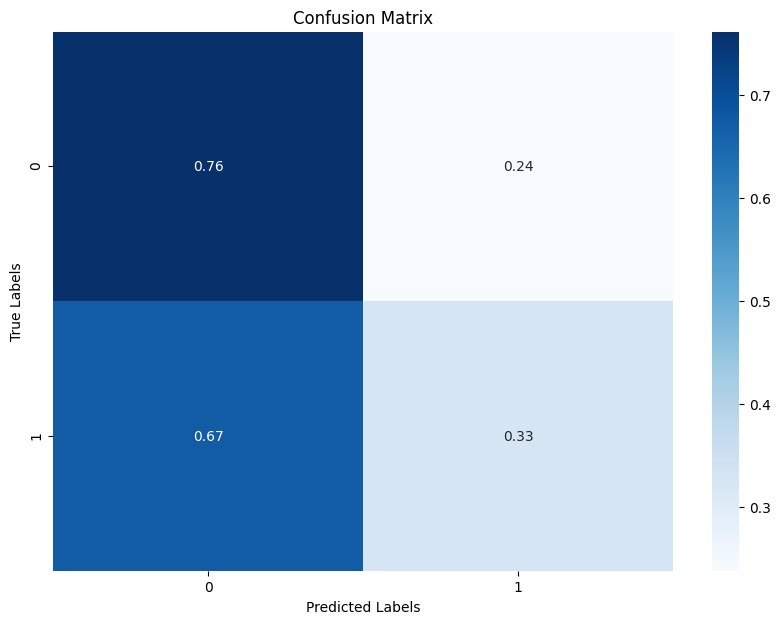

In [27]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True,  cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## What is the accuracy score telling us?

The accuracy score is 0.5330459770114943. <br> 
It means that our model predicts correctly in 53.3% cases. <br>
Still, it's considered not the perfect indicator of the model performance (especially if the groups are unbalanced, which I believe is our case, considering how we had to drop the bmi% groups + we have household income groups, which also probably aren't very balanced.  

The groups are only refering to the target groups. Also our data is pretty well matched. So why isn't the model that accurate? 

## What is the confusion matrix telling us? 
The confusion matrix is a matrix of numbers that tell us where a model gets confused. Say, of 4 classes, what if the model is predicting 1 class wrong and that's driving the accuracy score down? <br> 
So, confusion matrix gives a more detailed breakdown of the model's performance, showing how many instances were correctly or incorrectly classified, and in what way. Here's what each part of the matrix is telling us:

- **<u>0-0 True Negative (Top Left, 0.76)</u>**: The proportion of actual negatives (low ssb) that were correctly identified by the model. 76% is a pretty good number, it means that the model is relatively good at identifying the low ssb group.
- **<u> 1-0 False Positive (Top Right, 0.24)</u>**: The proportion of actual negatives (low ssb) that were incorrectly identified as positives (high ssb). This is a type I error.
- **<u> 0-1 False Negative (Bottom Left, 0.67)</u>**: The proportion of actual positives (high ssb) that were incorrectly identified as negatives (low ssb). This is a type II error and is quite high, indicating that the model often fails to identify positive instances (high ssb).
- **<u> 1-1 True Positive (Bottom Right, 0.33)</u>**: The proportion of actual positives (high ssb) that were correctly identified by the model. <br> 33% value is low, which means that our model is not very effective at correctly identifying positive instances (high ssb).

## 0s - low ssb group, 1s - high ssb group 

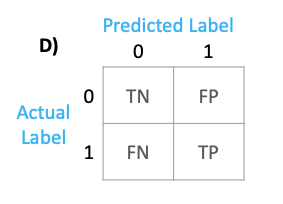

## Which target is classified the best? 

Low ssb groups

# To DO 7
1. Get the best parameters from the best model using the code below
2. Get the features as columns

In [28]:
# Access the best set of parameters found by GridSearchCV
best_parameters = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_parameters)

# Access the best estimator directly
best_model = grid_search.best_estimator_
print("Best model:", best_model)


Best parameters found by GridSearchCV: {'anova__k': 58, 'svc__C': 0.1}
Best model: Pipeline(steps=[('anova', SelectKBest(k=58)),
                ('svc', SVC(C=0.1, kernel='linear'))])


In [29]:
# Access the feature selection step ('anova' in your case)
feature_selection_step = best_model.named_steps['anova']
# Get the mask of selected features (boolean array)
selected_features_mask = feature_selection_step.get_support()
selected_columns = X_train.columns[selected_features_mask]


## What features best describe the targets?


In [30]:
selected_columns

Index(['rsfmri_c_ngd_ad_ngd_fo', 'rsfmri_c_ngd_ad_ngd_smh',
       'rsfmri_c_ngd_ad_ngd_smm', 'rsfmri_c_ngd_ad_ngd_vs',
       'rsfmri_c_ngd_ca_ngd_smm', 'rsfmri_c_ngd_ca_ngd_vta',
       'rsfmri_c_ngd_dla_ngd_smm', 'rsfmri_c_ngd_dla_ngd_vta',
       'rsfmri_c_ngd_smh_ngd_smh', 'rsfmri_c_ngd_smh_ngd_smm',
       'rsfmri_cor_ngd_au_scs_crcxlh', 'rsfmri_cor_ngd_au_scs_aalh',
       'rsfmri_cor_ngd_au_scs_vtdclh', 'rsfmri_cor_ngd_au_scs_ptrh',
       'rsfmri_cor_ngd_au_scs_hprh', 'rsfmri_cor_ngd_au_scs_vtdcrh',
       'rsfmri_cor_ngd_cerc_scs_cdelh', 'rsfmri_cor_ngd_cerc_scs_ptlh',
       'rsfmri_cor_ngd_cerc_scs_bs', 'rsfmri_cor_ngd_cerc_scs_aglh',
       'rsfmri_cor_ngd_cerc_scs_cderh', 'rsfmri_cor_ngd_cerc_scs_hprh',
       'rsfmri_cor_ngd_cerc_scs_agrh', 'rsfmri_cor_ngd_cerc_scs_vtdcrh',
       'rsfmri_cor_ngd_df_scs_ptlh', 'rsfmri_cor_ngd_df_scs_pllh',
       'rsfmri_cor_ngd_df_scs_aalh', 'rsfmri_cor_ngd_df_scs_vtdclh',
       'rsfmri_cor_ngd_df_scs_agrh', 'rsfmri_cor_ngd_df_scs_aarh

## How are the features similar or not? 

They are all brain regions, there's no bmi or ses

# Regression
Now we are going to try to predict the SSB intake at year 2 using the features from year 1

# To DO 8
1. Subset the X_test data so that it contains only the columns selected from the feature selection above call this X_regression
2. Create a X_trainReg, X_testReg, y_trainReg, y_testReg from the X_regression and y_test
3. Run a binary logistic model

In [31]:
# 1.Subset the X_test data to contain only the columns selected from the feature selection
X_regression = X_test[selected_columns]

#2. Create a X_trainReg, X_testReg, y_trainReg, y_testReg from the X_regression and y_test
X_trainReg, X_testReg, y_trainReg, y_testReg = train_test_split(X_regression, y_test, test_size=0.2, random_state=42)

In [32]:
X_regression

,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_smh,rsfmri_c_ngd_ad_ngd_smm,rsfmri_c_ngd_ad_ngd_vs,rsfmri_c_ngd_ca_ngd_smm,rsfmri_c_ngd_ca_ngd_vta,rsfmri_c_ngd_dla_ngd_smm,rsfmri_c_ngd_dla_ngd_vta,rsfmri_c_ngd_smh_ngd_smh,rsfmri_c_ngd_smh_ngd_smm,...,rsfmri_cor_ngd_smm_scs_thprh,rsfmri_cor_ngd_sa_scs_thplh,rsfmri_cor_ngd_sa_scs_ptlh,rsfmri_cor_ngd_vta_scs_crcxlh,rsfmri_cor_ngd_vta_scs_thplh,rsfmri_cor_ngd_vta_scs_aalh,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_aarh
1783,-0.077960,0.230909,0.249179,-0.077381,-0.222856,-0.023759,-0.050772,-0.086388,0.367033,0.249337,...,0.018807,0.049654,0.010003,-0.005459,-0.168745,0.052456,0.017440,-0.033974,0.090539,-0.055008
3783,-0.031333,0.124799,0.199452,-0.148135,-0.102100,-0.210872,-0.111297,-0.120219,0.387357,0.039307,...,0.339499,0.220748,0.163351,-0.034198,-0.382443,0.232204,0.300313,0.156102,0.194350,0.064285
4770,-0.108177,0.125863,0.251949,-0.056412,-0.153255,-0.093760,-0.091910,-0.218225,0.234895,0.068746,...,0.290599,0.196464,0.085940,0.090821,-0.122166,0.196260,-0.055628,-0.087577,-0.093962,0.010218
787,-0.161234,0.282762,0.331733,0.047727,-0.040451,-0.132688,-0.120867,-0.040030,0.479750,0.147392,...,-0.001099,0.023311,-0.001169,-0.129511,-0.274877,0.044931,-0.084533,-0.223378,-0.064418,-0.009114
798,-0.078163,0.158524,0.203225,0.041565,-0.022447,-0.099339,-0.018437,-0.059043,0.349661,0.219969,...,0.071264,0.094298,0.063782,-0.080408,-0.363660,-0.081938,-0.032597,-0.161841,-0.126608,0.014805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5154,-0.010537,0.128403,0.282788,-0.143732,-0.128903,0.031688,-0.008778,-0.073209,0.231504,-0.015897,...,0.374538,0.178351,0.061393,-0.012345,0.036809,0.292910,0.145693,0.043074,0.088134,-0.007974
4459,-0.008032,0.093061,0.175810,-0.063521,-0.193839,-0.094798,0.061954,-0.009579,0.195629,0.149220,...,0.078267,-0.058984,0.051690,-0.053906,0.053472,0.042240,0.074428,-0.089598,0.017834,-0.044747
1283,-0.035202,0.100327,0.291896,-0.023747,-0.186627,-0.127038,0.010058,-0.098534,0.288860,0.063448,...,0.335704,0.421725,0.096411,-0.061332,-0.038363,0.010854,0.045072,-0.025889,0.012139,0.002556
756,-0.071235,0.270678,0.176585,-0.073554,-0.033294,-0.213374,-0.067414,-0.060000,0.415116,0.185713,...,-0.043344,0.054523,0.084275,0.101406,-0.264926,0.295982,0.010197,-0.083365,-0.145887,0.049626


In [33]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)
# Fit the model on the training data
model.fit(X_trainReg, y_trainReg)
# Predict on the test set
y_predReg = model.predict(X_testReg)

# Calculate the accuracy
accuracyReg = accuracy_score(y_testReg, y_predReg)
print(f"Accuracy: {accuracyReg}")

# Coefficients
coefficients = model.coef_
# Intercepts
intercepts = model.intercept_

Accuracy: 0.44086021505376344


# To DO 9
1. Make a dataframe of the coefficeients and have the features at the columns names
2. Add an intercept column
3. Plot the figure

In [34]:
# 1. Make a dataframe of the coefficients and have the features as the column names
coeff_df = pd.DataFrame(coefficients, columns=X_regression.columns)

# 2. Add an intercept column
coeff_df['intercept'] = intercepts

coeff_df

,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_smh,rsfmri_c_ngd_ad_ngd_smm,rsfmri_c_ngd_ad_ngd_vs,rsfmri_c_ngd_ca_ngd_smm,rsfmri_c_ngd_ca_ngd_vta,rsfmri_c_ngd_dla_ngd_smm,rsfmri_c_ngd_dla_ngd_vta,rsfmri_c_ngd_smh_ngd_smh,rsfmri_c_ngd_smh_ngd_smm,...,rsfmri_cor_ngd_sa_scs_thplh,rsfmri_cor_ngd_sa_scs_ptlh,rsfmri_cor_ngd_vta_scs_crcxlh,rsfmri_cor_ngd_vta_scs_thplh,rsfmri_cor_ngd_vta_scs_aalh,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_aarh,intercept
0,-0.272341,0.222602,0.636042,-0.010397,0.520303,0.719428,0.020213,-0.647628,0.184846,0.610936,...,-0.436786,-0.28992,1.14366,0.28319,0.100589,-0.626532,-0.176039,0.088996,-0.240991,-0.428113


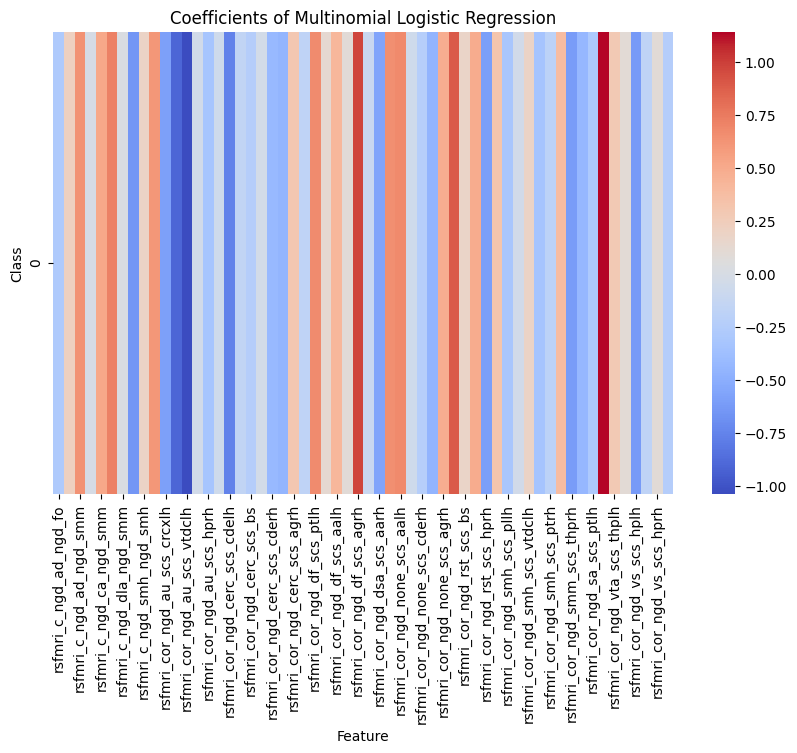

In [35]:
plt.figure(figsize=(10, 6))
sns.heatmap(coeff_df.iloc[:, :-1], annot=False, cmap='coolwarm')  # Exclude intercepts for visualization
plt.title('Coefficients of Multinomial Logistic Regression')
plt.ylabel('Class')
plt.xlabel('Feature')
plt.show()

# Summary
We now have done a basic logistic regression, but we want to see what features are signigicant predictors of SSB intake. We will use a different logistic regression package through statsmodels to get more details

In [36]:
# Assuming X_trainReg and y_trainReg are your training data and labels
# Add constant to the features for the intercept
X_test_reg_sm = sm.add_constant(X_testReg)


/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


# To DO 10
1. Replace 2 with 1 in the y_testReg target
2. Run the model

In [37]:
# 1. Replace 2 with 1 in the y_testReg target
y_testReg = y_testReg.replace(2, 1)


In [38]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_test_reg_sm)
result = logit_model.fit()
# Summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.527722
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              ssb_group   No. Observations:                  186
Model:                          Logit   Df Residuals:                      127
Method:                           MLE   Df Model:                           58
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                  0.2371
Time:                        14:52:07   Log-Likelihood:                -98.156
converged:                       True   LL-Null:                       -128.66
Covariance Type:            nonrobust   LLR p-value:                    0.3686
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.8427      1.239      0.680     

In [45]:
result.params

const                              0.842724
rsfmri_c_ngd_ad_ngd_fo           -12.534623
rsfmri_c_ngd_ad_ngd_smh           -0.518308
rsfmri_c_ngd_ad_ngd_smm           -3.604744
rsfmri_c_ngd_ad_ngd_vs             6.062062
rsfmri_c_ngd_ca_ngd_smm           -1.437187
rsfmri_c_ngd_ca_ngd_vta           -5.346147
rsfmri_c_ngd_dla_ngd_smm           5.395949
rsfmri_c_ngd_dla_ngd_vta          -4.419379
rsfmri_c_ngd_smh_ngd_smh          -3.664887
rsfmri_c_ngd_smh_ngd_smm           1.659536
rsfmri_cor_ngd_au_scs_crcxlh      -0.892715
rsfmri_cor_ngd_au_scs_aalh         2.667386
rsfmri_cor_ngd_au_scs_vtdclh       0.403611
rsfmri_cor_ngd_au_scs_ptrh        -1.278411
rsfmri_cor_ngd_au_scs_hprh         1.037199
rsfmri_cor_ngd_au_scs_vtdcrh       9.216080
rsfmri_cor_ngd_cerc_scs_cdelh     -5.474711
rsfmri_cor_ngd_cerc_scs_ptlh       4.491193
rsfmri_cor_ngd_cerc_scs_bs        -3.137211
rsfmri_cor_ngd_cerc_scs_aglh      -5.128009
rsfmri_cor_ngd_cerc_scs_cderh     -1.768373
rsfmri_cor_ngd_cerc_scs_hprh    

## What features are significantly related to SSB intake?

In [39]:
p_values = result.pvalues
significant_features = p_values[p_values < 0.05]
print(significant_features)

rsfmri_cor_ngd_cerc_scs_hprh      0.010505
rsfmri_cor_ngd_cerc_scs_vtdcrh    0.017187
rsfmri_cor_ngd_df_scs_aalh        0.026534
rsfmri_cor_ngd_none_scs_aalh      0.042448
rsfmri_cor_ngd_sa_scs_thplh       0.014235
dtype: float64


In [40]:
# Making predictions
predictions = result.predict(X_test_reg_sm)
# Converting probabilities to class labels
class_predictions = np.where(predictions > 0.5, 1, 0)
# The real target assignments
real = y_testReg.to_numpy()

# To DO 11
1. Make a dataframe with two columns 'real' (the actual target classes) and 'pred' (the predicted target classes)
2. Use the jaccard score to measure the accuracy of the model

In [41]:
# Create a dataframe with two columns 'real' and 'pred'
dfPrevReal = pd.DataFrame({
    'real': real,
    'pred': class_predictions
})

In [42]:
jaccard = jaccard_score(dfPrevReal['real'], dfPrevReal['pred'])
print("Jaccard Similarity Score:", jaccard)


Jaccard Similarity Score: 0.6


In [43]:
## Get getting the odds ratios

In [44]:
np.exp(result.params)


const                             2.322685e+00
rsfmri_c_ngd_ad_ngd_fo            3.599835e-06
rsfmri_c_ngd_ad_ngd_smh           5.955273e-01
rsfmri_c_ngd_ad_ngd_smm           2.719442e-02
rsfmri_c_ngd_ad_ngd_vs            4.292595e+02
rsfmri_c_ngd_ca_ngd_smm           2.375953e-01
rsfmri_c_ngd_ca_ngd_vta           4.766480e-03
rsfmri_c_ngd_dla_ngd_smm          2.205113e+02
rsfmri_c_ngd_dla_ngd_vta          1.204171e-02
rsfmri_c_ngd_smh_ngd_smh          2.560707e-02
rsfmri_c_ngd_smh_ngd_smm          5.256870e+00
rsfmri_cor_ngd_au_scs_crcxlh      4.095425e-01
rsfmri_cor_ngd_au_scs_aalh        1.440227e+01
rsfmri_cor_ngd_au_scs_vtdclh      1.497222e+00
rsfmri_cor_ngd_au_scs_ptrh        2.784794e-01
rsfmri_cor_ngd_au_scs_hprh        2.821302e+00
rsfmri_cor_ngd_au_scs_vtdcrh      1.005756e+04
rsfmri_cor_ngd_cerc_scs_cdelh     4.191441e-03
rsfmri_cor_ngd_cerc_scs_ptlh      8.922781e+01
rsfmri_cor_ngd_cerc_scs_bs        4.340369e-02
rsfmri_cor_ngd_cerc_scs_aglh      5.928355e-03
rsfmri_cor_ng

In [46]:
# Double check

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



In [ ]:
# Fit the multinomial logistic regression model
#logit_model = sm.Logit(y_testReg, X_test_reg_sm)


In [49]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

logisticRegr = LogisticRegression()
logisticRegr.fit(X_test_reg_sm, y_testReg)

df=pd.DataFrame({'odds_ratio':(np.exp(logisticRegr.coef_).T).tolist(),'variable':X_test_reg_sm.columns.tolist()})
df['odds_ratio'] = df['odds_ratio'].str.get(0)

df=df.sort_values('odds_ratio', ascending=False)
df

,odds_ratio,variable
22,2.327738,rsfmri_cor_ngd_cerc_scs_hprh
51,1.745447,rsfmri_cor_ngd_sa_scs_ptlh
37,1.652053,rsfmri_cor_ngd_none_scs_agrh
23,1.630693,rsfmri_cor_ngd_cerc_scs_agrh
24,1.519489,rsfmri_cor_ngd_cerc_scs_vtdcrh
15,1.461803,rsfmri_cor_ngd_au_scs_hprh
20,1.414080,rsfmri_cor_ngd_cerc_scs_aglh
18,1.360249,rsfmri_cor_ngd_cerc_scs_ptlh
39,1.324066,rsfmri_cor_ngd_rst_scs_bs
11,1.273702,rsfmri_cor_ngd_au_scs_crcxlh


In [50]:
logisticRegr

LogisticRegression()

In [51]:
from sklearn.utils import resample
import numpy as np

# Define the number of bootstrap samples
n_bootstraps = 1000
coef_matrix = []

# Bootstrap loop
for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_test_reg_sm, y_testReg)
    logisticRegr.fit(X_sample, y_sample)
    coef_matrix.append(logisticRegr.coef_[0])

# Convert to numpy array for ease of calculation
coef_matrix = np.array(coef_matrix)

# Calculating percentiles for 95% confidence intervals
lower_bounds = np.percentile(coef_matrix, 2.5, axis=0)
upper_bounds = np.percentile(coef_matrix, 97.5, axis=0)

# Assuming you have a DataFrame 'df' with your coefficients and variable names
df['lower_ci'] = lower_bounds
df['upper_ci'] = upper_bounds

In [52]:
df

,odds_ratio,variable,lower_ci,upper_ci
22,2.327738,rsfmri_cor_ngd_cerc_scs_hprh,-0.000303,0.000501
51,1.745447,rsfmri_cor_ngd_sa_scs_ptlh,-0.600288,0.225482
37,1.652053,rsfmri_cor_ngd_none_scs_agrh,-0.585023,0.298550
23,1.630693,rsfmri_cor_ngd_cerc_scs_agrh,-0.904473,0.346693
24,1.519489,rsfmri_cor_ngd_cerc_scs_vtdcrh,-0.660307,0.420347
15,1.461803,rsfmri_cor_ngd_au_scs_hprh,-0.949095,0.458603
20,1.414080,rsfmri_cor_ngd_cerc_scs_aglh,-0.869773,0.465826
18,1.360249,rsfmri_cor_ngd_cerc_scs_ptlh,-0.342647,0.711660
39,1.324066,rsfmri_cor_ngd_rst_scs_bs,-0.752705,0.235301
11,1.273702,rsfmri_cor_ngd_au_scs_crcxlh,-0.712688,0.510493


In [53]:
X_with_const = sm.add_constant(X_test_reg_sm)  # Adding a constant for the intercept
logit_model = sm.Logit(y_testReg, X_with_const)
result = logit_model.fit()

# Extracting the p-values
p_values = result.pvalues

# Extracting the confidence intervals
conf_intervals = result.conf_int()

# Adding p-values and confidence intervals to your DataFrame
df_stats = pd.DataFrame({'variable': X_with_const.columns, 'coef': result.params, 'p_value': p_values})
df_stats['lower_ci'], df_stats['upper_ci'] = conf_intervals[0], conf_intervals[1]

print(df_stats)

Optimization terminated successfully.
         Current function value: 0.527722
         Iterations 7
                                                      variable       coef  \
const                                                    const   0.842724   
rsfmri_c_ngd_ad_ngd_fo                  rsfmri_c_ngd_ad_ngd_fo -12.534623   
rsfmri_c_ngd_ad_ngd_smh                rsfmri_c_ngd_ad_ngd_smh  -0.518308   
rsfmri_c_ngd_ad_ngd_smm                rsfmri_c_ngd_ad_ngd_smm  -3.604744   
rsfmri_c_ngd_ad_ngd_vs                  rsfmri_c_ngd_ad_ngd_vs   6.062062   
rsfmri_c_ngd_ca_ngd_smm                rsfmri_c_ngd_ca_ngd_smm  -1.437187   
rsfmri_c_ngd_ca_ngd_vta                rsfmri_c_ngd_ca_ngd_vta  -5.346147   
rsfmri_c_ngd_dla_ngd_smm              rsfmri_c_ngd_dla_ngd_smm   5.395949   
rsfmri_c_ngd_dla_ngd_vta              rsfmri_c_ngd_dla_ngd_vta  -4.419379   
rsfmri_c_ngd_smh_ngd_smh              rsfmri_c_ngd_smh_ngd_smh  -3.664887   
rsfmri_c_ngd_smh_ngd_smm              rsfmri_c_ngd_

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [54]:
# Regularization check
logisticRegr = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000)
# or for no regularization in newer versions
# logisticRegr = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)

In [56]:
from sklearn.preprocessing import StandardScaler


In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test_reg_sm)

In [59]:
X_scaled

array([[ 0.        ,  0.80114629, -0.74720167, ...,  0.85246349,
        -0.3310526 , -1.29527096],
       [ 0.        , -0.10819432, -1.21570824, ...,  0.7167376 ,
         0.40112393,  0.45667448],
       [ 0.        , -0.12838877,  0.79932594, ..., -0.56702343,
         0.02078745,  0.98167503],
       ...,
       [ 0.        , -1.44606366,  0.97264521, ..., -2.11462406,
        -0.78197953,  0.79367136],
       [ 0.        , -0.50481394, -0.89687758, ...,  0.23248166,
         0.42481165,  0.13678039],
       [ 0.        ,  0.9601072 , -0.48022695, ...,  1.52620254,
         0.65869941,  0.34510318]])

In [61]:
X_test_reg_sm

,const,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_smh,rsfmri_c_ngd_ad_ngd_smm,rsfmri_c_ngd_ad_ngd_vs,rsfmri_c_ngd_ca_ngd_smm,rsfmri_c_ngd_ca_ngd_vta,rsfmri_c_ngd_dla_ngd_smm,rsfmri_c_ngd_dla_ngd_vta,rsfmri_c_ngd_smh_ngd_smh,...,rsfmri_cor_ngd_smm_scs_thprh,rsfmri_cor_ngd_sa_scs_thplh,rsfmri_cor_ngd_sa_scs_ptlh,rsfmri_cor_ngd_vta_scs_crcxlh,rsfmri_cor_ngd_vta_scs_thplh,rsfmri_cor_ngd_vta_scs_aalh,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_aarh
4990,1.0,0.000144,0.068887,0.197993,-0.023126,-0.042877,-0.183845,-0.028767,-0.205254,0.236221,...,-0.064467,-0.058996,-0.087883,-0.012440,-0.228218,-0.023215,0.027261,0.038841,-0.019621,-0.104365
1420,1.0,-0.044571,0.035871,0.114620,0.015332,-0.127352,-0.112936,-0.029999,-0.121341,0.191234,...,0.086561,0.180868,0.042194,-0.007000,0.018355,-0.038534,0.018768,0.026832,0.083880,0.034894
4632,1.0,-0.045564,0.177869,0.224426,0.058579,-0.206003,-0.062955,0.010362,-0.014823,0.209273,...,0.130297,-0.025963,0.149486,0.161303,-0.165725,0.002614,-0.123188,-0.086754,0.030115,0.076626
4825,1.0,-0.000027,0.082809,0.099717,-0.057643,-0.138724,-0.115803,0.013814,-0.148553,0.242418,...,0.047680,0.121542,0.008127,-0.070705,-0.161523,0.027254,-0.037313,-0.072199,0.044305,-0.029183
4747,1.0,-0.052189,0.129282,0.178476,0.009857,0.014040,-0.037422,-0.001059,-0.076007,0.247887,...,0.110552,0.262127,-0.045283,0.067172,-0.184407,0.083018,0.103457,0.026020,0.067539,-0.063867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,1.0,-0.011716,0.101741,0.300961,-0.024935,-0.021554,-0.110488,0.033372,-0.048685,0.265880,...,0.261039,0.365446,-0.035849,-0.168835,-0.092638,-0.161030,0.150978,0.127057,0.171157,-0.001823
3983,1.0,-0.023892,0.052279,0.227208,-0.104314,-0.146382,-0.079369,-0.000007,-0.115619,0.247385,...,0.075005,0.059169,-0.007114,0.021217,-0.203035,0.038067,0.140047,0.015407,0.074823,-0.033732
676,1.0,-0.110359,0.190083,0.268866,0.059131,-0.089988,-0.112036,0.026618,0.006295,0.314462,...,0.128403,-0.012581,0.036123,0.112173,-0.212964,0.043532,0.139795,-0.223685,-0.083364,0.061681
4049,1.0,-0.064074,0.058339,0.092887,0.000357,-0.023007,-0.132479,0.074630,-0.198216,0.220537,...,0.051914,0.110763,0.035534,-0.048138,0.064457,0.025392,0.036035,-0.016014,0.087228,0.009466


In [62]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

logisticRegr = LogisticRegression()
logisticRegr.fit(X_scaled, y_testReg)

df=pd.DataFrame({'odds_ratio':(np.exp(logisticRegr.coef_).T).tolist(),'variable':X_test_reg_sm.columns.tolist()})
df['odds_ratio'] = df['odds_ratio'].str.get(0)

df=df.sort_values('odds_ratio', ascending=False)
df

,odds_ratio,variable
22,2.527665,rsfmri_cor_ngd_cerc_scs_hprh
24,2.131199,rsfmri_cor_ngd_cerc_scs_vtdcrh
27,1.850013,rsfmri_cor_ngd_df_scs_aalh
16,1.588156,rsfmri_cor_ngd_au_scs_vtdcrh
18,1.557024,rsfmri_cor_ngd_cerc_scs_ptlh
51,1.454937,rsfmri_cor_ngd_sa_scs_ptlh
23,1.433460,rsfmri_cor_ngd_cerc_scs_agrh
7,1.286809,rsfmri_c_ngd_dla_ngd_smm
26,1.282726,rsfmri_cor_ngd_df_scs_pllh
4,1.271423,rsfmri_c_ngd_ad_ngd_vs


In [67]:
X_scaled

array([[ 0.        ,  0.80114629, -0.74720167, ...,  0.85246349,
        -0.3310526 , -1.29527096],
       [ 0.        , -0.10819432, -1.21570824, ...,  0.7167376 ,
         0.40112393,  0.45667448],
       [ 0.        , -0.12838877,  0.79932594, ..., -0.56702343,
         0.02078745,  0.98167503],
       ...,
       [ 0.        , -1.44606366,  0.97264521, ..., -2.11462406,
        -0.78197953,  0.79367136],
       [ 0.        , -0.50481394, -0.89687758, ...,  0.23248166,
         0.42481165,  0.13678039],
       [ 0.        ,  0.9601072 , -0.48022695, ...,  1.52620254,
         0.65869941,  0.34510318]])

In [66]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_scaled)
result = logit_model.fit()
# Summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.528750
         Iterations 7


LinAlgError: Singular matrix

In [64]:
np.exp(result.params)


const                             2.322685e+00
rsfmri_c_ngd_ad_ngd_fo            3.599835e-06
rsfmri_c_ngd_ad_ngd_smh           5.955273e-01
rsfmri_c_ngd_ad_ngd_smm           2.719442e-02
rsfmri_c_ngd_ad_ngd_vs            4.292595e+02
rsfmri_c_ngd_ca_ngd_smm           2.375953e-01
rsfmri_c_ngd_ca_ngd_vta           4.766480e-03
rsfmri_c_ngd_dla_ngd_smm          2.205113e+02
rsfmri_c_ngd_dla_ngd_vta          1.204171e-02
rsfmri_c_ngd_smh_ngd_smh          2.560707e-02
rsfmri_c_ngd_smh_ngd_smm          5.256870e+00
rsfmri_cor_ngd_au_scs_crcxlh      4.095425e-01
rsfmri_cor_ngd_au_scs_aalh        1.440227e+01
rsfmri_cor_ngd_au_scs_vtdclh      1.497222e+00
rsfmri_cor_ngd_au_scs_ptrh        2.784794e-01
rsfmri_cor_ngd_au_scs_hprh        2.821302e+00
rsfmri_cor_ngd_au_scs_vtdcrh      1.005756e+04
rsfmri_cor_ngd_cerc_scs_cdelh     4.191441e-03
rsfmri_cor_ngd_cerc_scs_ptlh      8.922781e+01
rsfmri_cor_ngd_cerc_scs_bs        4.340369e-02
rsfmri_cor_ngd_cerc_scs_aglh      5.928355e-03
rsfmri_cor_ng

In [65]:
p_values = result.pvalues
significant_features = p_values[p_values < 0.05]
print(significant_features)


rsfmri_cor_ngd_cerc_scs_hprh      0.010505
rsfmri_cor_ngd_cerc_scs_vtdcrh    0.017187
rsfmri_cor_ngd_df_scs_aalh        0.026534
rsfmri_cor_ngd_none_scs_aalh      0.042448
rsfmri_cor_ngd_sa_scs_thplh       0.014235
dtype: float64
